In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from typing import List

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, recall_score, balanced_accuracy_score, precision_score, precision_recall_curve, auc, roc_auc_score

import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
al_train = pd.read_csv('../AL00_datasets/AL_training_data_tox21_mmp_chembl_mito_safe_join.csv')
al_train

,chemical name,InChIKey,standardised_smiles,source,mitochondrial toxic
0,ESTRADIOL CYPIONATE,UOACKFBJUYNSLK-XRKIENNPSA-N,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,tox21_mmp,toxic
1,TERT-BUTYLHYDROQUINONE,BGNXCDMCOKJUMV-UHFFFAOYSA-N,CC(C)(C)c1cc(O)ccc1O,tox21_mmp,toxic
2,MALACHITE GREEN OXALATE,CNYGFPPAGUCRIC-UHFFFAOYSA-L,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)c...,tox21_mmp,toxic
3,5424-37-3,GKQYGRWQCWWSHN-UHFFFAOYSA-N,Cc1cc(N)c2cc(NC(=O)Nc3ccc4nc(C)cc(N)c4c3)ccc2n...,tox21_mmp,toxic
4,BUCLIZINE DIHYDROCHLORIDE,SDBHDSZKNVDKNU-UHFFFAOYSA-N,CC(C)(C)c1ccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)C...,tox21_mmp,toxic
...,...,...,...,...,...
1973,RITLECITINIB TOSYLATE,YOZLVAFWYLSRRN-VZXYPILPSA-N,C=CC(=O)N1C[C@H](Nc2ncnc3[nH]ccc23)CC[C@@H]1C....,chembl_mito_safe_drugs,non-toxic
1974,UPADACITINIB HEMIHYDRATE,GJMQTRCDSIQEFK-SCDRJROZSA-N,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,chembl_mito_safe_drugs,non-toxic
1975,ODEVIXIBAT SESQUIHYDRATE,UIYFGCAQGONAMU-ZHQCGWDOSA-N,CCCCC1(CCCC)CN(c2ccccc2)c2cc(SC)c(OCC(=O)N[C@@...,chembl_mito_safe_drugs,non-toxic
1976,TECOVIRIMAT MONOHYDRATE,QRHXYGPOQKLBJP-NPIFKJBVSA-N,O.O=C(NN1C(=O)[C@@H]2[C@@H]3C=C[C@@H]([C@H]4C[...,chembl_mito_safe_drugs,non-toxic


In [9]:
def _compute_single_morgan_fp(smiles: str):
  try:
    mol = Chem.MolFromSmiles(smiles)
  except Exception as E:
    return None

  if mol:
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    return np.array(fp)

  return None


def compute_morgan_fps(smiles_list: List[str]):
    #computes Morgan fps for a list of SMILES

  keep_idx = []
  descriptors = []
  for i, smiles in enumerate(smiles_list):
    ecfp = _compute_single_morgan_fp(smiles)
    if ecfp is not None:
      keep_idx.append(i)
      descriptors.append(ecfp)

  descriptors_arr = np.vstack(descriptors)
  df = pd.DataFrame(data=descriptors_arr, index=keep_idx)
  df.index.name = "Index"
  df = df.reset_index()
  df.insert(1, "standardised_smiles", pd.Series(smiles_list)[keep_idx].values)

  return df

# Generate Morgan fingerprints for complete AL training data and then create randomised subset of 20% for internal test

In [10]:
al_train_fp = compute_morgan_fps(al_train["standardised_smiles"])
al_train_fp.drop(["Index"], axis=1, inplace=True)
al_train_fp

,standardised_smiles,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,CC(C)(C)c1cc(O)ccc1O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)c...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,Cc1cc(N)c2cc(NC(=O)Nc3ccc4nc(C)cc(N)c4c3)ccc2n...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CC(C)(C)c1ccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)C...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,C=CC(=O)N1C[C@H](Nc2ncnc3[nH]ccc23)CC[C@@H]1C....,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1974,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1975,CCCCC1(CCCC)CN(c2ccccc2)c2cc(SC)c(OCC(=O)N[C@@...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1976,O.O=C(NN1C(=O)[C@@H]2[C@@H]3C=C[C@@H]([C@H]4C[...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [11]:
al_train_mitotox = al_train[['standardised_smiles','mitochondrial toxic']]

al_train_activity_fp = pd.merge(al_train_fp, al_train_mitotox, on='standardised_smiles')

al_train_activity_fp["mitochondrial toxic"] = al_train_activity_fp["mitochondrial toxic"].replace("toxic", 1)
al_train_activity_fp["mitochondrial toxic"] = al_train_activity_fp["mitochondrial toxic"].replace("non-toxic", 0)

al_train_activity_fp

,standardised_smiles,0,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,mitochondrial toxic
0,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,CC(C)(C)c1cc(O)ccc1O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)c...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,Cc1cc(N)c2cc(NC(=O)Nc3ccc4nc(C)cc(N)c4c3)ccc2n...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,CC(C)(C)c1ccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)C...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,C=CC(=O)N1C[C@H](Nc2ncnc3[nH]ccc23)CC[C@@H]1C....,0,0,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1974,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1975,CCCCC1(CCCC)CN(c2ccccc2)c2cc(SC)c(OCC(=O)N[C@@...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1976,O.O=C(NN1C(=O)[C@@H]2[C@@H]3C=C[C@@H]([C@H]4C[...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [12]:
X = al_train_activity_fp.drop(columns=['standardised_smiles', 'mitochondrial toxic'])
y = al_train_activity_fp['mitochondrial toxic']

In [13]:
# Split data: 80% Training + 20% Internal Test

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

len(X_test), len(y_test)

(396, 396)

In [14]:
al_training_holdout = X_test.merge(y_test.to_frame(), left_index=True, right_index=True)
al_training_holdout

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,mitochondrial toxic
1259,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1905,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1483,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1958,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1620,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
#al_training_holdout.to_csv('../AL00_datasets/al_training_data_hold_out_set_ecfp4.csv')

In [16]:
# Ensure all feature names are strings
X_train_full.columns = X_train_full.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

/Users/tmp/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


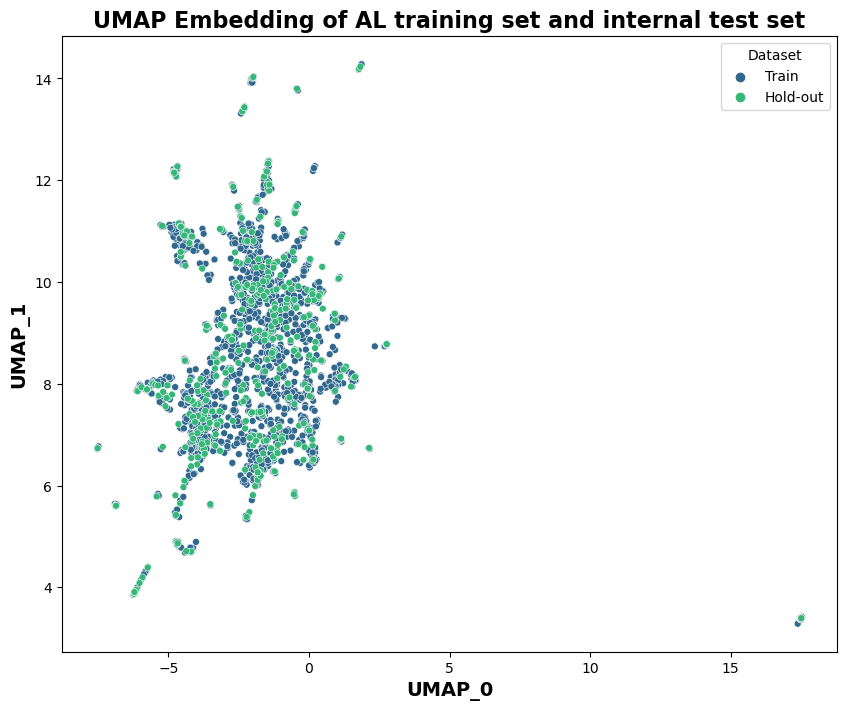

In [17]:
labels1 = ["Train"] * len(X_train_full)
labels2 = ["Hold-out"] * len(X_test)

# Combine datasets and labels
combined_data = np.vstack([X_train_full, X_test])
combined_labels = np.array(labels1 + labels2)

# Apply umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(combined_data)

# Create df for visualisation
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df["Dataset"] = combined_labels

# Plot umap
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df, x="UMAP1", y="UMAP2", hue="Dataset", palette="viridis", alpha=1, s=25
)
plt.title("UMAP Embedding of AL training set and internal test set", fontsize=16, weight='bold')
plt.xlabel("UMAP_0", fontsize=14, weight='bold')
plt.ylabel("UMAP_1", fontsize=14, weight='bold')
plt.legend(title="Dataset")

# Save plot
#plt.savefig("../umap_al_train_internal_test_sets.png", dpi=600, bbox_inches="tight")

plt.show()


In [19]:
# GridSearchCV parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100, 1000],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [20]:
# Define parameters
sample_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_runs = 10  # number of times random sampling occurs for each subset size
param_grid = {
    'n_estimators': [10, 50, 100, 1000],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

results = [] # list to store all results
train_data_dict = {} # dictionary to store dfs for all subset sizes and their repeats

# Iterate through the percentages of the dataset
for pct in tqdm(sample_size, total=len(sample_size)):
    print(f"\nTraining with {int(pct * 100)}% of the training data...")
    
    subset_results = []  # list to store metrics for all runs of this subset size
    
    for run in range(1, n_runs + 1):
        print(f"Run {run}/{n_runs} for {int(pct * 100)}% subset size...")
        
        # handle the 100% case where we use the entire training set
        if pct == 1.0:
            X_train_subset, y_train_subset = X_train_full, y_train_full
        else:
            # split the training data into a subset for this iteration
            X_train_subset, _, y_train_subset, _ = train_test_split(
                X_train_full, y_train_full, train_size=pct, random_state=42 + run, stratify=y_train_full
            )
        
        
        # store AL training data split in a dict
        subset_key = f"{int(pct * 100)}_pct_run_{run}"
        train_data = X_train_subset.copy()
        train_data['mitochondrial toxic'] = y_train_subset
        train_data_dict[subset_key] = train_data
        
        # ensure X_test only contains feature columns
        if 'mitochondrial toxic' in X_test.columns:
            X_test = X_test.drop(columns=['mitochondrial toxic'])
        
        # tune random forest (RF) model using GridSearchCV
        rf_model = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_subset, y_train_subset)

        best_model = grid_search.best_estimator_

        y_test_probas = best_model.predict_proba(X_test)
        
        # predict test set
        y_test_pred = best_model.predict(X_test)

        # calculate performance metrics
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        
        test_roc_auc = roc_auc_score(y_test, y_test_probas[:, 1])
        test_sensitivity = recall_score(y_test, y_test_pred)
        test_specificity = recall_score(y_test, y_test_pred, pos_label=0)
        test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
        test_ppv = precision_score(y_test, y_test_pred)
        test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_probas[:, 1])
        test_pr_auc = auc(test_recall, test_precision)

        
        # store individual run results
        subset_results.append({
            'percentage': int(pct * 100),
            'run': run,
            'accuracy': test_accuracy,
            'f1_score': test_f1,
            'rmse': test_rmse,
            'r2': test_r2,
            'roc_auc': test_roc_auc,
            'sensitivity': test_sensitivity,
            'specificity': test_specificity,
            'balanced_acc': test_balanced_acc,
            'ppv': test_ppv,
            'precision': test_precision,
            'recall': test_recall,
            'pr_auc': test_pr_auc
            
        })
    
    # average performance metrics across all runs for this subset size
    subset_df = pd.DataFrame(subset_results)
    avg_metrics = subset_df.mean(numeric_only=True).to_dict()
    avg_metrics.update({'percentage': int(pct * 100), 'run': 'average'})
    results.append(avg_metrics)
    
    # save individual results
#     subset_df.to_csv(
#         f"../AL03_1_diff_training_subset_size_performance_individual/test_individual_results_{int(pct * 100)}_pct.csv",
#         index=False
#     )

# create df of averged results
results_df = pd.DataFrame(results)

# save averaged results
# results_df.to_csv(
#     '../AL03_2_diff_training_subset_size_performance_avg/test_al_train_hold_out_diff_subset_sizes_performance_avg.csv',
#     index=False
# )

print("All metrics saved. Final averaged results:")
print(results_df)

  0%|                                                    | 0/10 [00:00<?, ?it/s]


Training with 10% of the training data...
Run 1/10 for 10% subset size...
Run 2/10 for 10% subset size...
Run 3/10 for 10% subset size...
Run 4/10 for 10% subset size...
Run 5/10 for 10% subset size...
Run 6/10 for 10% subset size...
Run 7/10 for 10% subset size...
Run 8/10 for 10% subset size...
Run 9/10 for 10% subset size...
Run 10/10 for 10% subset size...


 10%|████                                    | 1/10 [23:47<3:34:06, 1427.36s/it]


Training with 20% of the training data...
Run 1/10 for 20% subset size...
Run 2/10 for 20% subset size...
Run 3/10 for 20% subset size...
Run 4/10 for 20% subset size...
Run 5/10 for 20% subset size...
Run 6/10 for 20% subset size...
Run 7/10 for 20% subset size...
Run 8/10 for 20% subset size...
Run 9/10 for 20% subset size...
Run 10/10 for 20% subset size...


 20%|████████                                | 2/10 [54:50<3:44:28, 1683.59s/it]


Training with 30% of the training data...
Run 1/10 for 30% subset size...
Run 2/10 for 30% subset size...
Run 3/10 for 30% subset size...
Run 4/10 for 30% subset size...
Run 5/10 for 30% subset size...
Run 6/10 for 30% subset size...
Run 7/10 for 30% subset size...
Run 8/10 for 30% subset size...
Run 9/10 for 30% subset size...
Run 10/10 for 30% subset size...


 30%|███████████▍                          | 3/10 [1:20:28<3:08:40, 1617.15s/it]


Training with 40% of the training data...
Run 1/10 for 40% subset size...
Run 2/10 for 40% subset size...
Run 3/10 for 40% subset size...
Run 4/10 for 40% subset size...
Run 5/10 for 40% subset size...
Run 6/10 for 40% subset size...
Run 7/10 for 40% subset size...
Run 8/10 for 40% subset size...
Run 9/10 for 40% subset size...
Run 10/10 for 40% subset size...


 40%|███████████████▏                      | 4/10 [1:50:57<2:50:05, 1700.89s/it]


Training with 50% of the training data...
Run 1/10 for 50% subset size...
Run 2/10 for 50% subset size...
Run 3/10 for 50% subset size...
Run 4/10 for 50% subset size...
Run 5/10 for 50% subset size...
Run 6/10 for 50% subset size...
Run 7/10 for 50% subset size...
Run 8/10 for 50% subset size...
Run 9/10 for 50% subset size...
Run 10/10 for 50% subset size...


 50%|███████████████████                   | 5/10 [2:22:29<2:27:27, 1769.58s/it]


Training with 60% of the training data...
Run 1/10 for 60% subset size...
Run 2/10 for 60% subset size...
Run 3/10 for 60% subset size...
Run 4/10 for 60% subset size...
Run 5/10 for 60% subset size...
Run 6/10 for 60% subset size...
Run 7/10 for 60% subset size...
Run 8/10 for 60% subset size...
Run 9/10 for 60% subset size...
Run 10/10 for 60% subset size...


 60%|██████████████████████▊               | 6/10 [2:57:38<2:05:40, 1885.22s/it]


Training with 70% of the training data...
Run 1/10 for 70% subset size...
Run 2/10 for 70% subset size...
Run 3/10 for 70% subset size...
Run 4/10 for 70% subset size...
Run 5/10 for 70% subset size...
Run 6/10 for 70% subset size...
Run 7/10 for 70% subset size...
Run 8/10 for 70% subset size...
Run 9/10 for 70% subset size...
Run 10/10 for 70% subset size...


 70%|██████████████████████████▌           | 7/10 [3:49:14<1:54:02, 2280.96s/it]


Training with 80% of the training data...
Run 1/10 for 80% subset size...
Run 2/10 for 80% subset size...
Run 3/10 for 80% subset size...
Run 4/10 for 80% subset size...
Run 5/10 for 80% subset size...
Run 6/10 for 80% subset size...
Run 7/10 for 80% subset size...
Run 8/10 for 80% subset size...
Run 9/10 for 80% subset size...
Run 10/10 for 80% subset size...


 80%|██████████████████████████████▍       | 8/10 [4:45:07<1:27:24, 2622.42s/it]


Training with 90% of the training data...
Run 1/10 for 90% subset size...
Run 2/10 for 90% subset size...
Run 3/10 for 90% subset size...
Run 4/10 for 90% subset size...
Run 5/10 for 90% subset size...
Run 6/10 for 90% subset size...
Run 7/10 for 90% subset size...
Run 8/10 for 90% subset size...
Run 9/10 for 90% subset size...
Run 10/10 for 90% subset size...


 90%|██████████████████████████████████▏   | 9/10 [6:37:50<1:05:16, 3916.66s/it]


Training with 100% of the training data...
Run 1/10 for 100% subset size...
Run 2/10 for 100% subset size...
Run 3/10 for 100% subset size...
Run 4/10 for 100% subset size...
Run 5/10 for 100% subset size...
Run 6/10 for 100% subset size...
Run 7/10 for 100% subset size...
Run 8/10 for 100% subset size...
Run 9/10 for 100% subset size...
Run 10/10 for 100% subset size...


100%|███████████████████████████████████████| 10/10 [8:57:01<00:00, 3222.14s/it]

All metrics saved. Final averaged results:
   percentage      run  accuracy  f1_score      rmse        r2   roc_auc  \
0          10  average  0.762121  0.770854  0.486974  0.048096  0.852163   
1          20  average  0.799242  0.795009  0.447799  0.196642  0.876124   
2          30  average  0.809596  0.804528  0.436202  0.238073  0.887811   
3          40  average  0.819697  0.813967  0.424457  0.278493  0.896957   
4          50  average  0.831566  0.824992  0.410274  0.325988  0.903468   
5          60  average  0.842172  0.835984  0.397238  0.368429  0.909622   
6          70  average  0.844949  0.839247  0.393505  0.379545  0.914848   
7          80  average  0.853788  0.848129  0.382041  0.414913  0.919006   
8          90  average  0.861111  0.856021  0.372565  0.444218  0.919475   
9         100  average  0.868687  0.863158  0.362372  0.474533  0.927618   

   sensitivity  specificity  balanced_acc       ppv    pr_auc  
0     0.784158     0.739175      0.761667  0.760254  0.8

In [21]:
for key, df in train_data_dict.items():
    df.to_csv(f'../AL03_3_all_training_subset_dataframes/{key}_df.csv')
    print(f'Saved: {key}')

Saved: 10_pct_run_1
Saved: 10_pct_run_2
Saved: 10_pct_run_3
Saved: 10_pct_run_4
Saved: 10_pct_run_5
Saved: 10_pct_run_6
Saved: 10_pct_run_7
Saved: 10_pct_run_8
Saved: 10_pct_run_9
Saved: 10_pct_run_10
Saved: 20_pct_run_1
Saved: 20_pct_run_2
Saved: 20_pct_run_3
Saved: 20_pct_run_4
Saved: 20_pct_run_5
Saved: 20_pct_run_6
Saved: 20_pct_run_7
Saved: 20_pct_run_8
Saved: 20_pct_run_9
Saved: 20_pct_run_10
Saved: 30_pct_run_1
Saved: 30_pct_run_2
Saved: 30_pct_run_3
Saved: 30_pct_run_4
Saved: 30_pct_run_5
Saved: 30_pct_run_6
Saved: 30_pct_run_7
Saved: 30_pct_run_8
Saved: 30_pct_run_9
Saved: 30_pct_run_10
Saved: 40_pct_run_1
Saved: 40_pct_run_2
Saved: 40_pct_run_3
Saved: 40_pct_run_4
Saved: 40_pct_run_5
Saved: 40_pct_run_6
Saved: 40_pct_run_7
Saved: 40_pct_run_8
Saved: 40_pct_run_9
Saved: 40_pct_run_10
Saved: 50_pct_run_1
Saved: 50_pct_run_2
Saved: 50_pct_run_3
Saved: 50_pct_run_4
Saved: 50_pct_run_5
Saved: 50_pct_run_6
Saved: 50_pct_run_7
Saved: 50_pct_run_8
Saved: 50_pct_run_9
Saved: 50_pct_ru